# Jackknife examples

In this notebook we will show how to estimate the covariance of the correlation function based on jackknife estimates, following https://arxiv.org/pdf/2109.07071.pdf.
Look first at notebook basic_examples.ipynb to understand the *pycorr* API.

In [1]:
import os
import tempfile

import numpy as np
from matplotlib import pyplot as plt

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging

# To activate logging
setup_logging()

In [2]:
def generate_catalogs(size=10000, boxsize=(1000,)*3, offset=(1000., 0., 0.), n_individual_weights=1, seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(0., 1., size)*b for o, b in zip(offset, boxsize)]
    weights = [rng.uniform(0.5, 1., size) for i in range(n_individual_weights)]
    return positions, weights

In [3]:
# First, generate fake data with cartesian positions and weights
boxsize = np.full(3, 1000.)
boxcenter = np.full(3, 1000.)
offset = boxcenter - boxsize/2.
positions, weights = generate_catalogs(size=10000, boxsize=boxsize, offset=offset, seed=42)

## Split in subsamples
Let us divide the box into subregions.

[000000.03]  06-15 23:02  BoxSubsampler                INFO     Labels from 0 to 124.


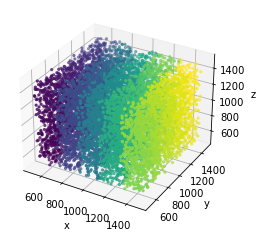

In [4]:
from pycorr import BoxSubsampler
subsampler = BoxSubsampler(boxsize=boxsize, boxcenter=boxcenter, nsamples=6**3)
labels = subsampler.label(positions)
subsampler.log_info('Labels from {:d} to {:d}.'.format(labels.min(), labels.max()))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*positions, marker='.', c=labels)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Check jackknife estimates
Let us generate many simulations to test jackknife estimates.

In [5]:
edges = np.linspace(0., 90, 46)
setup_logging('warning')  # reduce logging
num = 20
results = []
for ii in range(num):
    if (ii * 10) % num == 0:
        print('Simulation {:d}/{:d}.'.format(ii, num))
    data_positions, data_weights = generate_catalogs(size=10000, boxsize=boxsize, offset=offset, n_individual_weights=1, seed=ii+42)
    randoms_positions, randoms_weights = generate_catalogs(size=50000, boxsize=boxsize, offset=offset, n_individual_weights=1, seed=ii+84)
    data_samples = subsampler.label(data_positions)
    randoms_samples = subsampler.label(randoms_positions)
    result = TwoPointCorrelationFunction('s', edges, data_positions1=data_positions, data_weights1=data_weights,
                                         randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                         data_samples1=data_samples, randoms_samples1=randoms_samples,
                                         engine='corrfunc', compute_sepsavg=False, nthreads=4)
    results.append(result)

Simulation 0/20.
Simulation 2/20.
Simulation 4/20.
Simulation 6/20.
Simulation 8/20.
Simulation 10/20.
Simulation 12/20.
Simulation 14/20.
Simulation 16/20.
Simulation 18/20.


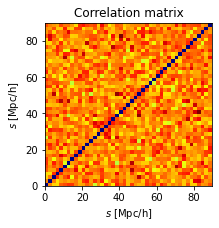

In [6]:
result = results[0]
sep = result.sep
cov = result.cov()

corrcoef = utils.cov_to_corrcoef(result.cov())

fig = plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.pcolor(sep, sep, corrcoef.T, cmap=plt.get_cmap('jet_r'))
ax.set_title('Correlation matrix')
ax.set_xlabel(r'$s$ [Mpc/h]')
ax.set_ylabel(r'$s$ [Mpc/h]')
plt.show()

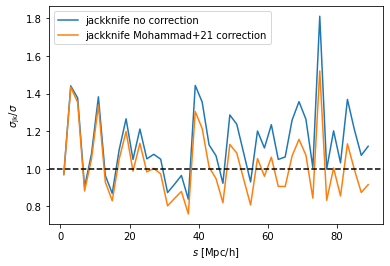

In [7]:
std = np.std([result.corr for result in results], axis=0, ddof=1)
jackknife_std_nocorr = np.mean([np.diag(result.cov(correction=None))**0.5 for result in results], axis=0)
jackknife_std_corr = np.mean([np.diag(result.cov())**0.5 for result in results], axis=0)

ax = plt.gca()
ax.plot(sep, jackknife_std_nocorr/std, label='jackknife no correction')
ax.plot(sep, jackknife_std_corr/std, label='jackknife Mohammad+21 correction')
ax.axhline(1., xmin=0., xmax=1., color='k', linestyle='--')
ax.set_xlabel(r'$s$ [Mpc/h]')
ax.set_ylabel(r'$\sigma_{\mathrm{jk}}/\sigma$')
ax.legend()
plt.show()

## Cutsky geometry
Let us try with more realistic cutsky catalogs.

In [8]:
def generate_cutsky_catalogs(size=10000, rarange=(0., 30.), decrange=(0., 30.), drange=(1000., 2000.), n_individual_weights=1, seed=42):
    rng = np.random.RandomState(seed=seed)
    ra = rng.uniform(low=rarange[0], high=rarange[1], size=size) % 360.
    urange = np.sin(np.asarray(decrange) * np.pi / 180.)
    dec = np.arcsin(rng.uniform(low=urange[0], high=urange[1], size=size)) / (np.pi / 180.)
    d = rng.uniform(low=drange[0], high=drange[1], size=size)
    positions = [ra, dec, d]
    weights = [rng.uniform(0.5, 1., size) for i in range(n_individual_weights)]
    return positions, weights

In [9]:
positions, weights = generate_cutsky_catalogs(size=100000, seed=42)

# Catalogs do not have a box geometry, so we will try to subsample using k-means algorithms in RA/Dec (pixelated) space
# Requires scikit-learn and healpy: pip install scikit-learn healpy
from pycorr import KMeansSubsampler
subsampler = KMeansSubsampler(mode='angular', positions=positions, nsamples=128, nside=512, random_state=42, position_type='rdd')
labels = subsampler.label(positions)
subsampler.log_info('Labels from {:d} to {:d}.'.format(labels.min(), labels.max()))

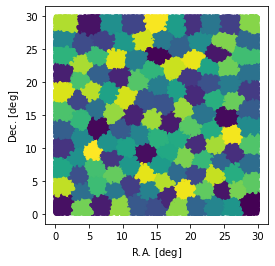

In [10]:
fig = plt.figure(figsize=(4, 4))
ax = plt.gca()
ax.scatter(*positions[:2], marker='.', c=labels)
ax.set_xlabel(r'R.A. [$\mathrm{deg}$]')
ax.set_ylabel(r'Dec. [$\mathrm{deg}$]')
plt.show()

In [11]:
data_positions, data_weights = generate_cutsky_catalogs(size=100000, seed=42)
randoms_positions, randoms_weights = generate_cutsky_catalogs(size=200000, seed=84)
data_samples = subsampler.label(data_positions)
randoms_samples = subsampler.label(randoms_positions)
edges = (np.linspace(0, 40, 41), np.linspace(-1., 1., 201))
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions, data_weights1=data_weights,
                                     randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                     data_samples1=data_samples, randoms_samples1=randoms_samples, position_type='rdd',
                                     engine='corrfunc', compute_sepsavg=False, nthreads=4)

In [12]:
# You can save the result
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.save(fn)
    result = TwoPointEstimator.load(fn)

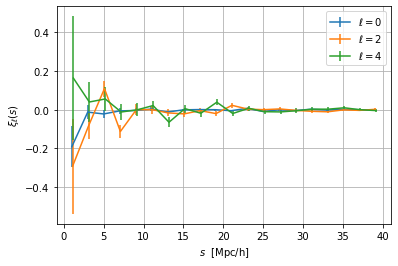

In [13]:
ells = (0, 2, 4)
nells = len(ells)
# Let us rebin by 2 along first dimension (s)
result = result[::2]
s, xiell, cov = result.get_corr(ells=ells, return_sep=True, return_cov=True)
std = np.array_split(np.diag(cov)**0.5, nells)
ax = plt.gca()
for ill,ell in enumerate(ells):
    ax.errorbar(s + ill * 0.1, xiell[ill], std[ill], fmt='-', label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$s$  [Mpc/h]')
ax.set_ylabel(r'$\xi_{\ell}(s)$')
plt.show()

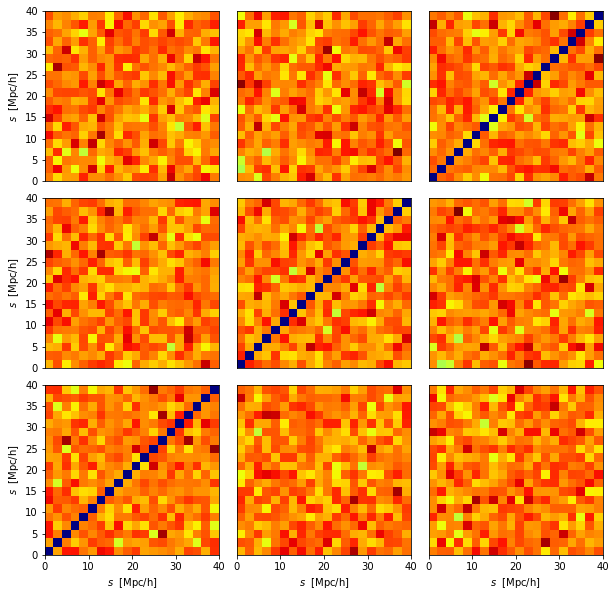

In [14]:
ns = len(s)
corrcoef = utils.cov_to_corrcoef(cov)
fig, lax = plt.subplots(nrows=nells, ncols=nells, sharex=False, sharey=False, figsize=(10,10), squeeze=False)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
from matplotlib.colors import Normalize
norm = Normalize(vmin=corrcoef.min(), vmax=corrcoef.max())
for i in range(nells):
    for j in range(nells):
        ax = lax[nells-1-i][j]
        mesh = ax.pcolor(s, s, corrcoef[i*ns:(i+1)*ns,j*ns:(j+1)*ns].T, norm=norm, cmap=plt.get_cmap('jet_r'))
        if i>0: ax.xaxis.set_visible(False)
        else: ax.set_xlabel(r'$s$  [Mpc/h]')
        if j>0: ax.yaxis.set_visible(False)
        else: ax.set_ylabel(r'$s$  [Mpc/h]')
plt.show()

## MPI

All computations above are MPI'ed (if available). Below is an example script to run correlation function (jackknife) estimation with MPI, with 2 MPI processes per "jackknife realization".

In [15]:
%%file '_tests/script.py'

import os

import numpy as np

from pycorr import KMeansSubsampler, TwoPointCorrelationFunction, mpi, setup_logging

# Set up logging
setup_logging()

def generate_cutsky_catalogs(size=10000, rarange=(0.,30), decrange=(0., 30.), drange=(1000., 2000.), n_individual_weights=1, seed=42):
    rng = np.random.RandomState(seed=seed)
    ra = rng.uniform(low=rarange[0], high=rarange[1], size=size) % 360.
    urange = np.sin(np.asarray(decrange) * np.pi / 180.)
    dec = np.arcsin(rng.uniform(low=urange[0], high=urange[1], size=size)) / (np.pi / 180.)
    d = rng.uniform(low=drange[0], high=drange[1], size=size)
    positions = [ra, dec, d]
    weights = [rng.uniform(0.5, 1., size) for i in range(n_individual_weights)]
    return positions, weights

mpicomm = mpi.COMM_WORLD
mpiroot = 0

# We generate catalog on a single process
if mpicomm.rank == mpiroot:
    data_positions, data_weights = generate_cutsky_catalogs(size=100000, seed=42)
    randoms_positions, randoms_weights = generate_cutsky_catalogs(size=200000, seed=84)
else:
    data_positions, data_weights = None, None
    randoms_positions, randoms_weights = None, None

subsampler = KMeansSubsampler(mode='angular', positions=randoms_positions, nsamples=128, nside=512, position_type='rdd',
                              random_state=42, mpicomm=mpicomm, mpiroot=mpiroot)
# mpiroot tells KMeansSubsampler to get positions on process mpiroot only;
# If input positions and weights arrays are scattered, pass mpiroot=None (default)
if mpicomm.rank == mpiroot:
    data_samples = subsampler.label(data_positions)
    randoms_samples = subsampler.label(randoms_positions)
else:
    data_samples, randoms_samples = None, None 

edges = (np.linspace(0., 40, 21), np.linspace(-1., 1., 101))
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions, data_weights1=data_weights,
                                     randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                     data_samples1=data_samples, randoms_samples1=randoms_samples, position_type='rdd',
                                     engine='corrfunc', compute_sepsavg=False, nthreads=1,
                                     mpicomm=mpicomm, mpiroot=mpiroot, nprocs_per_real=2)
# Notice mpiroot again, and nprocs_per_real=2 => 2 MPI processes per "jackknife realization"

base_dir = '_tests'
fn = os.path.join(base_dir, 'correlation.npy')
result.save(fn)

Overwriting _tests/script.py


In [16]:
%%bash
mpiexec -n 3 python _tests/script.py

[000093.60]  06-15 23:06  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_jackknife.JackknifeLandySzalayTwoPointEstimator'>.
[000093.60]  06-15 23:06  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000093.61]  06-15 23:06  MPITaskManager               INFO     Entering MPITaskManager with 1 workers.
[000093.70]  06-15 23:06  numexpr.utils                INFO     NumExpr defaulting to 8 threads.
[000093.70]  06-15 23:06  numexpr.utils                INFO     NumExpr defaulting to 8 threads.
[000104.20]  06-15 23:06  numexpr.utils                INFO     NumExpr defaulting to 8 threads.
[000104.46]  06-15 23:06  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000104.49]  06-15 23:06  MPITaskManager               INFO     Entering MPITaskManager with 1 workers.
[000133.89]  06-15 23:07  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000133.93]  06-15 23:07  MPITaskManager               

In [17]:
!ls -l _tests

total 74428
-rw-r--r-- 1 adematti idphp 76205899 Jun 15 23:07 correlation.npy
-rw-r--r-- 1 adematti idphp     2448 Jun 15 23:05 script.py
drwxr-x--- 2 adematti idphp     4096 Jun 10 10:28 _tests


## Split calculation
One can split the full jackknife calculation into several parts (e.g. to distribute on a cluster without using MPI), by specifying the subsamples to consider for the current calculation.

In [18]:
list_samples = np.array_split(np.unique(np.concatenate([data_samples, randoms_samples])), 3) # split calculation in 3 parts
results = []
for samples in list_samples:
    results.append(TwoPointCorrelationFunction('smu', result.edges, data_positions1=data_positions, data_weights1=data_weights,
                                               randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                               data_samples1=data_samples, randoms_samples1=randoms_samples, position_type='rdd',
                                               engine='corrfunc', compute_sepsavg=False, nthreads=4, samples=samples))
# Notice the keyword "samples" that list the samples to consider for each calculation
result_split = results[0].concatenate(*results)
s_split, xiell_split, cov_split = result_split.get_corr(ells=ells, return_sep=True, return_cov=True)
assert np.allclose(s_split, s)
assert np.allclose(xiell_split, xiell)
assert np.allclose(cov_split, cov)